In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


/usr/local/lib/python3.8/dist-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = False)
sim.run()

In [6]:
distances = np.arange(1,41,1) * u.kpc
dt = 1 * u.ms
trials = 1000
Smax_gen2, Smax_ic86 = [], []
eps_gen2, eps_ic86 = [], [] 
for i, d in enumerate(distances):
    print('distance {:.0f}'.format(d))
    # scale the simulation to the right distance
    sim.scale_result(distance=d)
    
    # signal
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
    t, s_dc = sim.detector_hits(dt=dt, subdetector='dc', size=trials)
    t, s_md = sim.detector_hits(dt=dt, subdetector='md', size=trials)
    
    np.sum(s_md, axis=1)

    # combined signal/background of subdetector components (i3,dc,md)
    s_ic86 = s_i3 + s_dc
    s_gen2 = s_i3 + s_dc + s_md

    # take average of maximum of SASI light curve over trials
    Smax_gen2.append(np.max(s_gen2, axis=1).mean())
    Smax_ic86.append(np.max(s_ic86, axis=1).mean())
    
    # A weighted sum to estimate the overall detector 'deadtime eff', there is a better way to do this I am 100% certain
    eps_ic86.append((sim.eps_dc.sum() + sim.eps_i3.sum()) / 
                (sim.detector.n_dc_doms + sim.detector.n_i3_doms))
    eps_gen2.append((sim.eps_md.sum() + sim.eps_dc.sum() + sim.eps_i3.sum()) / 
                (sim.detector.n_md + sim.detector.n_dc_doms + sim.detector.n_i3_doms))
Smax_ic86=np.array(Smax_ic86)
Smax_gen2=np.array(Smax_gen2)
eps_ic86 = np.array(eps_ic86)
eps_gen2 = np.array(eps_gen2)

distance 1 kpc
distance 2 kpc
distance 3 kpc
distance 4 kpc
distance 5 kpc
distance 6 kpc
distance 7 kpc
distance 8 kpc
distance 9 kpc
distance 10 kpc
distance 11 kpc
distance 12 kpc
distance 13 kpc
distance 14 kpc
distance 15 kpc
distance 16 kpc
distance 17 kpc
distance 18 kpc
distance 19 kpc
distance 20 kpc
distance 21 kpc
distance 22 kpc
distance 23 kpc
distance 24 kpc
distance 25 kpc
distance 26 kpc
distance 27 kpc
distance 28 kpc
distance 29 kpc
distance 30 kpc
distance 31 kpc
distance 32 kpc
distance 33 kpc
distance 34 kpc
distance 35 kpc
distance 36 kpc
distance 37 kpc
distance 38 kpc
distance 39 kpc
distance 40 kpc


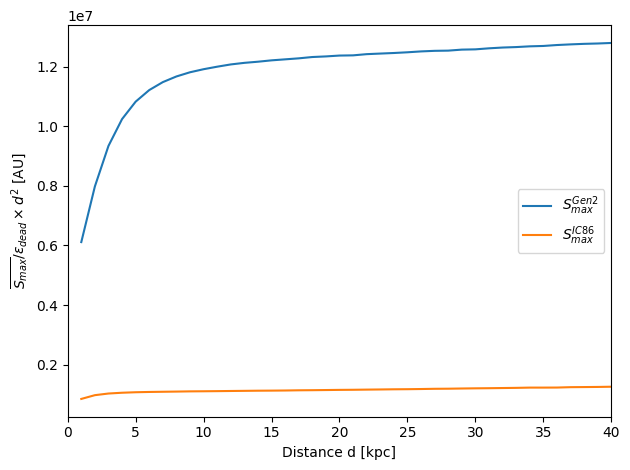

In [7]:
fig, ax = plt.subplots(1,1)


ax.plot(distances,Smax_gen2/eps_gen2*distances**2,label=r'$S_{max}^{Gen2}$')
ax.plot(distances,Smax_ic86/eps_ic86*distances**2,label=r'$S_{max}^{IC86}$')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Counts/bin')
ax.set_xlabel('Distance d [kpc]')
ax.set_ylabel(r'$\overline{S_{max}}/\epsilon_{dead} \times d^2$ [AU]')
ax.set_xlim((0,40))
ax.legend()
plt.tight_layout()

In [5]:
sim.

SyntaxError: invalid syntax (1756745460.py, line 1)